In [1]:
# Import libraries

import pandas as pd
import datetime as dt 
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import regex as re
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
import os
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt

2023-02-01 17:15:56.900159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vigneshsridhar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



# Data Processing


In [2]:
# Load .txt file data and create DataFrame

with open("Train_text.txt") as f:
    train_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Train_labels.txt") as f:
    train_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
with open("Test_text.txt") as f:
    test_text = pd.DataFrame([text for text in f], columns=["Content"])
with open("Test_labels.txt") as f:
    test_lab = pd.DataFrame([int(label.rstrip()) for label in f], columns=["Sentiment"])
text_df = pd.concat([train_text, test_text]).reset_index()
labels_df = pd.concat([train_lab, test_lab]).reset_index()
sentiment_df = pd.concat([text_df, labels_df], axis=1).reset_index()[["Content","Sentiment"]]
sentiment_df.head(10)

,Content,Sentiment
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2
5,@user LIT MY MUM 'Kerry the louboutins I wonde...,2
6,"""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...",2
7,So disappointed in wwe summerslam! I want to s...,0
8,"""This is the last Sunday w/o football .....,NF...",2
9,@user @user CENA & AJ sitting in a tree K-I-S-...,1


In [3]:
# Clean data

labels = list(sentiment_df["Sentiment"])

stopword = nltk.corpus.stopwords.words('english')
stopword = [re.sub("[^a-z]", "", word) for word in stopword] # Filter punctuation

tweets_clean = []
for i in range(len(sentiment_df)):
    tweet_raw = sentiment_df["Content"].iloc[i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean.append(tweet_edit_5.strip())

In [4]:
# Shuffle the data.

tweets_clean, labels = zip(*random.sample(list(zip(tweets_clean,labels)), len(tweets_clean)))
tweets_clean = list(tweets_clean)
labels = list(labels)

# Train-test split.

trainsize = int(len(tweets_clean)*0.8)

train_tweets, train_labels = tweets_clean[:trainsize], labels[:trainsize]
test_tweets, test_labels = tweets_clean[trainsize:], labels[trainsize:]

In [5]:
# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 20

# Tokenize text data, converting to integers.

tokenizer = Tokenizer(oov_token="<OOV>",
                      num_words=vocab_size)
tokenizer.fit_on_texts(train_tweets)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
test_sequences = tokenizer.texts_to_sequences(test_tweets)

# Pad sequences to standardise input sequence length.

train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

# Model Training


In the preprocessing above, we have removed punctuation, stopwords- commmonly used words in the english language such as *as,the,a* as well as removing emojis, which are commonly present in tweets. This allows us to pass pure words as inputs to the Neural Network Model. Also, because tweets are of different lengths, we have to have a predetermined vector size of 20 words, which have to be paddded if the tweet is less than that. We need to standardise the input as this is the only way to make predictions using our neural network model

In [6]:
def learning_curve(history):
    plt.figure(figsize=(10,12))

    # Loss subplot.
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

    # Accuracy subplot.
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

In [7]:
# Compile model.
embedding_dim = 16

model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Display model architecture.
model_1.summary()

# Train model.
history_1 = model_1.fit(train_padded, tf.one_hot(train_labels,3),
                    verbose=2,
                    epochs=15,
                    validation_data=(test_padded, tf.one_hot(test_labels,3)))

2023-02-01 17:16:25.952784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          320000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 lstm (LSTM)                 (None, 2)                 152       
                                                                 
 dropout_1 (Dropout)         (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
Total params: 320,161
Trainable params: 320,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1448/1448 - 10s - loss: 0.9569 - accura

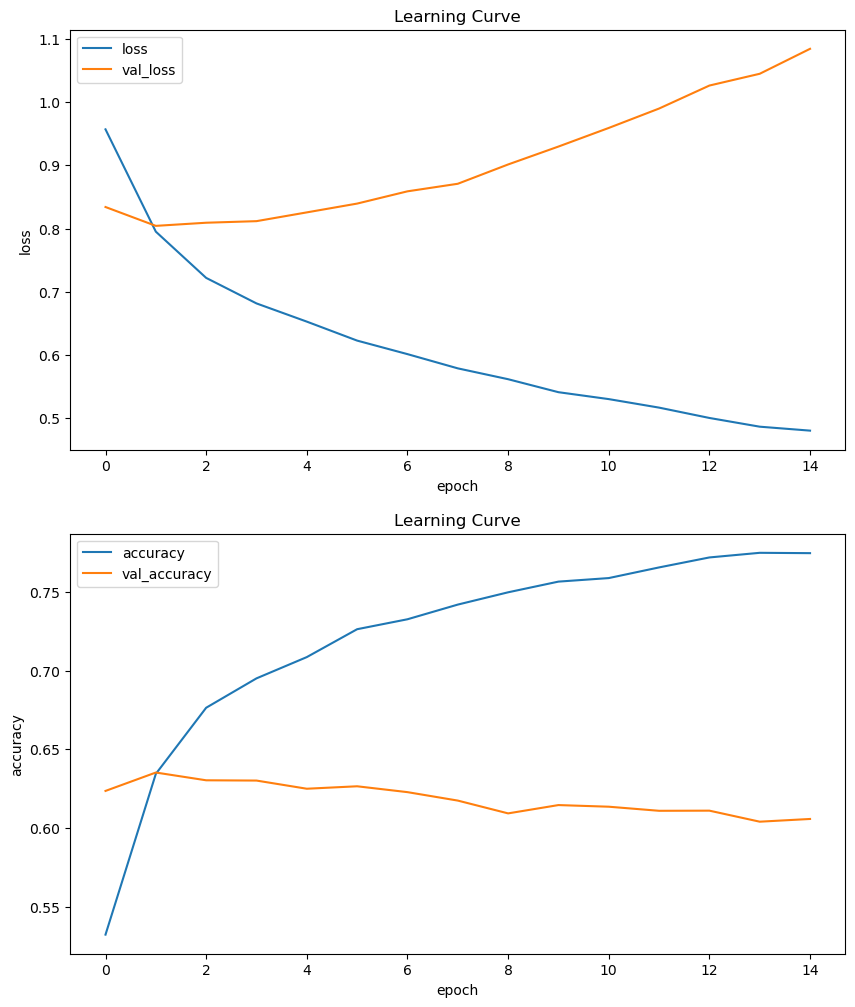

In [8]:
learning_curve(history_1)

# Sentiment Analysis

In [9]:
# Read and format the twitter scrape .csv file
# Add the .csv file to the workspace or this won't work

tweets_df = pd.read_csv("Twitter Scrape 2_Reduced.csv", usecols=['ID', 'Date', 'Likes', 'Replies', 'Retweets', 'User ID', 'Username', 
                                                                 'Followers', 'Verified', 'Content', 'Time', 'Category'],
                        encoding="UTF-8")
tweets_df["Time"] = pd.to_datetime(tweets_df["Time"], format='%H:%M:%S').dt.time
tweets_df["Date"] = pd.to_datetime(tweets_df["Date"], format='%d/%m/%Y').dt.date


tweets_clean = []
for i in range(len(tweets_df)):
    tweet_raw = tweets_df["Content"][i]
    tweet_edit_1 = re.sub("@user", "", tweet_raw.lower())
    tweet_edit_2 = re.sub(r"\\u....", "", tweet_edit_1) # Remove unicode strings
    tweet_edit_3 = ""
    for word in tweet_edit_2.split(" "):
        if word not in stopword:
            tweet_edit_3 = tweet_edit_3 + " " + word # Remove stopwords
    tweet_edit_4 = re.sub(r"[^a-zA-Z0-9\s\.]", "", tweet_edit_3) # Filter punctuation
    tweet_edit_5 = re.sub(" \.|\. ", "", tweet_edit_4) # Get rid of fullstops that are outside of words (e.g. 'u.s' remains)
    tweets_clean.append(tweet_edit_5.strip())

print(str(len(tweets_clean)))
# Preprocessing hyperparameters.

vocab_size = 20000
max_length = 20

# Tokenize text data, converting to integers.


sequences = tokenizer.texts_to_sequences(tweets_clean)


# Pad sequences to standardise input sequence length.

padded_sequences = pad_sequences(sequences, maxlen=max_length)

print(str(len(padded_sequences)))


3489
3489


In [10]:
sentimient_prediction = model_1.predict(padded_sequences)


110/110 [==============================] - 1s 2ms/step


In [11]:
Sentiment = []
for i in range(len(sentimient_prediction)):
  labels = sentimient_prediction[i]
  largest = 0
  largest_index = 0
  for j in range(3):
    if labels[j] > largest:
      largest = labels[j]
      largest_index = j 
  Sentiment.append(largest_index)

    
print(str(len(Sentiment)))

    

3489


In [12]:
tweets_df['Sentiment'] = Sentiment

tweets_df


,ID,Date,Likes,Replies,Retweets,User ID,Username,Followers,Verified,Content,Time,Category,Sentiment
0,1.448530e+18,2021-10-14,4457,659,1852,1.339170e+18,GBNEWS,474702,1,"ðŸ’‰ 'Everyone should be doing it, or none at ...",05:52:05,News,1
1,1.448540e+18,2021-10-14,20,77,8,1.339170e+18,GBNEWS,474702,1,'We have to wake up and get serious about this...,06:36:31,News,2
2,1.448560e+18,2021-10-14,425,38,125,1.195030e+18,COP26,246676,1,â° 30 seconds of #COP26 ðŸŒ\n\nWe asked our ...,07:45:32,International Organisation,1
3,1.448580e+18,2021-10-14,562,292,142,4.417791e+08,ScotGovFM,240289,1,"""When it comes to tackling climate change, siz...",09:30:14,Politician,1
4,1.448590e+18,2021-10-14,3,0,1,1.441903e+07,wirereporter,9211,1,"""By the time Glasgowâ€™s over, weâ€™re going t...",10:16:14,Journalist,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,1.464270e+18,2021-11-26,374,30,189,1.195030e+18,COP26,246626,1,"ðŸ—£ï¸ ""What was achieved at COP26?""\n\nThe #...",16:17:38,International Organisation,1
3485,1.464340e+18,2021-11-26,76,5,20,3.299212e+09,EmpireFiles,120526,1,ðŸ”’NEW PODCAST // Inside #COP26 w/ @AbbyMarti...,21:03:09,Misc,1
3486,1.464350e+18,2021-11-26,8,0,2,1.021880e+18,DohaDebates,1319106,1,"""I want to hear firsthand how these world lead...",22:00:02,Misc,0
3487,1.464550e+18,2021-11-27,157,12,68,1.195030e+18,COP26,246625,1,"""Rather than art as decoration, I think art is...",11:00:00,International Organisation,2


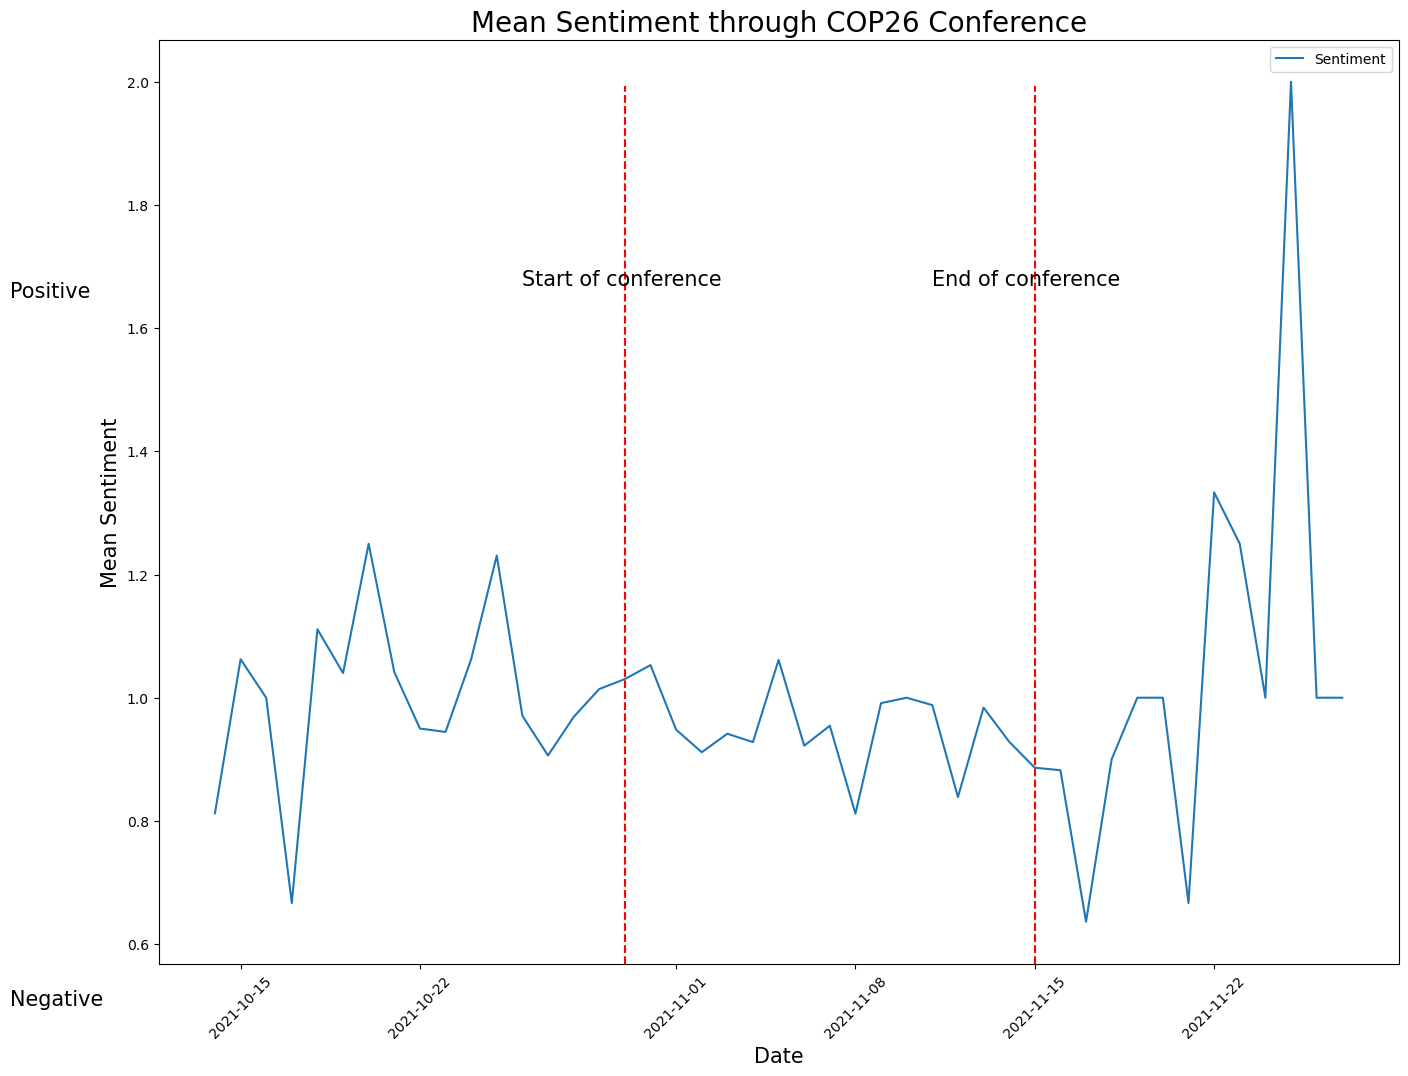

In [13]:
d = tweets_df.groupby(['Date'])['Sentiment'].mean().reset_index()

d.plot(x='Date',y='Sentiment',kind = 'line', rot = 45,figsize=(16,12))
plt.title("Mean Sentiment through COP26 Conference",fontsize = 20)
plt.ylabel("Mean Sentiment",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.axvline(18930, 0, 0.95 , color="red", linestyle="--")
plt.axvline(18946, 0, 0.95 , color="red", linestyle="--")
plt.text(18926, 1.67, "Start of conference",fontsize = 15)
plt.text(18942, 1.67, "End of conference",fontsize = 15)
plt.text(18906,1.65,"Positive", rotation=0,fontsize=15)
plt.text(18906,0.5,"Negative", rotation=0,fontsize=15)
plt.savefig("Sentiment_Change.svg")



In [14]:
tweets_df['Sentiment'].value_counts()[0]

755

In [15]:
tweets_df['Sentiment'].value_counts()[1]

2123

In [16]:
tweets_df['Sentiment'].value_counts()[2]

611